In [4]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot

In [6]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

#printing the shapes of the vectors 
print('Shapes of the mnist data:')
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

Shapes of the mnist data:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


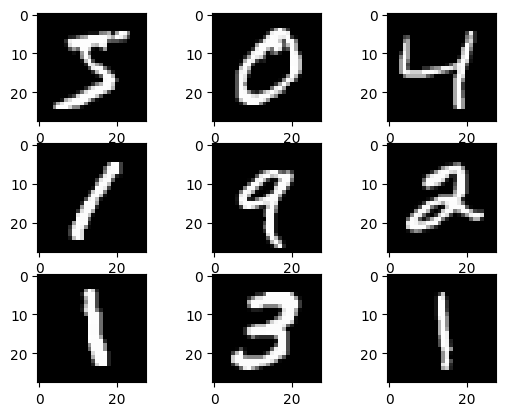

In [12]:
for i in range(9):
    # some sus syntax -> 330 + 1 + i means
    # 3x3 grid. (+1 + i) is the position in the grid
    # ...SUS :/
    # it's the same as pyplot.subplot(3, 3, i+1)
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))


In [ ]:
class Network:
    """
    Configurable neural net

    Attributes:
        num_layers: number of layers the net has
        sizes: list of neurons at each layer
        biases: list of bias vectors, where each bias vector
            holds the biases for a given layer. input layer
            has no bias on the neurons obvs
        weights: list of weights matrices, where each weight
            matrix holds the matrix of weights for a given layer.
            matrix size is N x M where:
            N - number of neurons at current layer (l)
            M - number of neurons at next layer (l + 1)            
    """
    def __init__(self, sizes):
        """
        Construct network of layers and rand init for weights & biases

        Args:
            sizes: list holds the number of neurons
                at each layer
       """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(b) for b in sizes[1:]]
        self.weights = [np.random.randn(x, y)
                        for (x,y) in zip(sizes[:-1], sizes[1:])]

    def metadata(self):
        """
        Prints the metadata of this class
        """
        print('=============\nNetwork metadata:')
        print('=============')
        print(f'Layers: {self.num_layers}')
        print(f'Sizes: {self.sizes}')
        
        print(f'Biases: {[np.asarray(b).shape for b in self.biases]}')
        print(f'Weights: {[np.asarray(w).shape for w in self.weights]}')

    def feedforward(self):
        """
        esentially we need to do the a = sig(wa^l-1 + b)
        for all layers until we compute a^L
        """
        pass

    def SGD(self):
        """
        stoch grad desc
        for each epoch, for each mini batch in a batch:
        we wanna compute the following for each mini batch:
        dc/dw, dc/db, error for the output and hidden layers
        if using minibatches we'll just accumulate gradients
        throughout the epoch, i think at the end we can just
        perform an avg of the gradient accum / num of mini batches
        need to use extra storage for this
        mini batch should be shuffled too for each epoch
        """
        pass

    def update_mini_batch(self):
        """
        for a given mini batch which should have x,y where:
        x - training data
        y - label
        compute the grad of w,b then accumulate this until
        the entire batch has been processed
        after the entire backwards pass just update the weights
        and biases with the avg'd accumulated grads
        """

    def backprop(self):
        """
        do the backwards pass, init za zero'd bias and weights matrix
        compute output delta
        compute delta at each layer
        return the biases and weights grads for each network layer
        """
        pass

    def cost_derivative(self):
        """
        for now probs just the MSE
        deriv of MSE implemented (simple)
        """

# Misc functions - probs can be part of a utils/math/linalg lib
def sigmoid(self):
    """
    impl sigmoid activation algo
    """
    pass

def sigmoid_derivative(self):
    """
    impl sigmoid derivative
    """
    pass


In [26]:
net = Network([10, 20, 300, 10])
net.metadata()

Start of Network metadata:
Layers: 4
Sizes: [10, 20, 300, 10]
Biases: [(20,), (300,), (10,)]
Weights: [(10, 20), (20, 300), (300, 10)]
End of Network metadata:
